In [26]:
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, average_precision_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import roc_auc_score, precision_recall_curve

from sklearn.pipeline import FeatureUnion
from sklearn.metrics import confusion_matrix
from functools import partial
from src.features.url_classification import classifier_LICA, classifier_DFR
import more_itertools as mit
from urllib.parse import urlparse
from sklearn.metrics.pairwise import cosine_similarity
import lightgbm as lgb

import tensorflow as tf
import tensorflow_hub as hub
import keras.layers as layers
from keras.models import Model
from keras import backend as K
np.random.seed(10)

from joblib import dump, load

In [67]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

In [6]:
DIR = '../../data/processed/test'
crawls = glob.glob('{}/media_test.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df_test = pd.read_csv(last_crawl)

In [7]:
df_test.shape

(72, 14)

In [8]:
df_test.label.value_counts()

false      32
mixture    25
true       15
Name: label, dtype: int64

In [9]:
df_test[df_test.claim.str.contains('video',regex=False, case=False)].label.value_counts()

mixture    8
false      7
true       1
Name: label, dtype: int64

In [10]:
df_test = df_test[df_test.label!='mixture']

In [11]:
df_test = df_test[~df_test.claim.str.contains('video',regex=False, case=False)]

In [12]:
df_test.label.value_counts()

false    25
true     14
Name: label, dtype: int64

In [13]:
df_test.label.value_counts(normalize=True)

false    0.641026
true     0.358974
Name: label, dtype: float64

In [19]:
DIR = '../../data/processed'

In [20]:
crawls = glob.glob('{}/snopes/media_2019*.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df_snopes = pd.read_csv(last_crawl)
df_snopes = df_snopes[df_snopes.label!='mixture']
df_snopes = df_snopes[~df_snopes.claim.str.contains('video',regex=False, case=False)]

In [21]:
crawls = glob.glob('{}/reuters/media_2019*.csv'.format(DIR))
last_crawl = sorted(crawls)[-1]
df_reuters = pd.read_csv(last_crawl)
df_reuters.label = 'true'

In [22]:
df_snopes.shape, df_reuters.shape

((838, 15), (395, 14))

In [23]:
df_labels_snopes = pd.read_csv('{}/snopes/known_articles_labeled.csv'.format(DIR)).set_index('url')
df_labels_reuters = pd.read_csv('{}/reuters/known_articles_labeled_reuters.csv'.format(DIR)).set_index('url')
df_labels_test = pd.read_csv('{}/test/known_articles_labeled_test.csv'.format(DIR)).set_index('url')
df_labels = pd.concat([df_labels_snopes, df_labels_reuters, df_labels_test], axis=0)
df_labels = df_labels[~df_labels.index.duplicated(keep='first')]

In [24]:
df_labels_true = df_labels[df_labels.media_label == 'TRUE']
all_claims = pd.concat([df_snopes,df_reuters], sort=True, axis=0).claim
documents = list(df_labels_true['title'].fillna('')) + list(df_labels_true['text'].fillna('')) + list(all_claims)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vectorizer.fit(documents)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [29]:
dump(tfidf_vectorizer, 'persisted/cos_sim_vectorizer.joblib')

['persisted/cos_sim_vectorizer.joblib']

In [30]:
cos_sim_vectorizer = load('persisted/cos_sim_vectorizer.joblib')

In [77]:
from src.features.vectorizing import prefix_analyzer, tag_tokenizer

In [31]:
dfr_clf = classifier_DFR.DFR()

skip_domains = ['com', 'co', 'net', 'org']

skip_common = ['photo', 'photos', 'photography', 'fotos',  'pictures', 'photograph', 'image']

def get_title(url, label):
    if url in df_labels.index and df_labels.loc[url]['media_label'] == label:
        return str(df_labels.loc[url].title)
    return ''

def get_summary(url, label):
    if url in df_labels.index and df_labels.loc[url]['media_label'] == label:
        return str(df_labels.loc[url].summary)
    return ''

def category_tokenizer(doc):
    #print('Calling tokenizer')
    return doc

def get_feature_names(pipeline):
    all_feature_names = []
    for transformer in pipeline.named_steps.union.transformer_list:
        for step in reversed(transformer[1].steps):
            if hasattr(step[1], 'get_feature_names'):
                all_feature_names += step[1].get_feature_names()
                #print("{} has {} features...".format(transformer[0], len(step[1].get_feature_names())))
                break
    return all_feature_names
    
def get_similarities(df, media_label, claims):
    urls = df.legal_page_urls
    urls = [y.strip(' \'"') for y in str(urls)[1:-1].split(',')]
    sub_df = df_labels[(df_labels.index.isin(urls)) & (df_labels.media_label == media_label)]
    if sub_df.shape[0] == 0:
        return []
    
    titles = cos_sim_vectorizer.transform(sub_df['title'].fillna(''))    
    texts = cos_sim_vectorizer.transform(sub_df['text'].fillna(''))
    
    sim_titles = cosine_similarity(claims[df.name], titles)[0]
    sim_texts = cosine_similarity(claims[df.name], texts)[0]

    return (sim_titles + sim_texts)/2

def get_use_embeddings(X):
    input_tensor_X = tf.placeholder(tf.string, shape=(None))
    encoding_tensor_X = embed(input_tensor_X)
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())

        return session.run(encoding_tensor_X, feed_dict={input_tensor_X: X})
    
def get_use_similarities(df, claim_embeddings, title_embeddings):
    urls = df.legal_page_urls
    urls = [y.strip(' \'"') for y in str(urls)[1:-1].split(',')]
    sub_df = df_labels_true[df_labels_true.index.isin(urls)]
    if sub_df.shape[0] == 0:
        return []
    
    claim_emb = claim_embeddings[df.name]
    title_emb = title_embeddings[sub_df.i]

    return np.inner(claim_emb, title_emb)

In [32]:
df_snopes_claim_embeddings = get_use_embeddings(df_snopes.claim)
df_reuters_claim_embeddings = get_use_embeddings(df_reuters.claim)
df_labels_true['i'] = range(len(df_labels_true))
title_embeddings = get_use_embeddings(df_labels_true.title.fillna(''))
df_snopes = df_snopes.reset_index(drop=True)
df_snopes['use_sim'] = df_snopes.apply(lambda x: get_use_similarities(
    x, df_snopes_claim_embeddings, title_embeddings), axis=1)
df_reuters['use_sim'] = df_reuters.apply(lambda x: get_use_similarities(
    x, df_reuters_claim_embeddings, title_embeddings), axis=1)

/home/didi/Documents/fake-image-detection/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
df_test_claim_embeddings = get_use_embeddings(df_test.claim)

In [34]:
df_test = df_test.reset_index(drop=True)
df_test['use_sim'] = df_test.apply(lambda x: get_use_similarities(
    x, df_test_claim_embeddings, title_embeddings), axis=1)

In [69]:
from src.models.estimators import BowSelector, ColumnSelector, MultipleSelector

In [36]:
def get_X_y(df_orig):
    df = df_orig.copy()
    #df = df[['legal_page_urls', 'descriptions', 'label','true_perc', 'false_perc','mixed_perc', 
    #         'known_count', 'total_count', 'claim']]
    df.legal_page_urls = df.legal_page_urls.apply(lambda x: [y.strip(' \'"') for y in str(x)[1:-1].split(',')])

    df['media_titles_true'] = df.legal_page_urls.map(lambda x: ' '.join([get_title(y, 'TRUE') for y in x]).strip())
    df['media_titles_false'] = df.legal_page_urls.map(
        lambda x: ' '.join([get_title(y, 'FALSE') for y in x]).strip())
    df['media_titles_mixed'] = df.legal_page_urls.map(
        lambda x: ' '.join([get_title(y, 'MIXED') for y in x]).strip())
    
    df['media_summaries_true'] = df.legal_page_urls.map(
        lambda x: ' '.join([get_summary(y, 'TRUE') for y in x]).strip())
    df['media_summaries_false'] = df.legal_page_urls.map(
        lambda x: ' '.join([get_summary(y, 'FALSE') for y in x]).strip())
    df['media_summaries_mixed'] = df.legal_page_urls.map(
        lambda x: ' '.join([get_summary(y, 'MIXED') for y in x]).strip())
        
        
    df['url_categories_dfr'] = df.legal_page_urls.apply(lambda x: list(mit.flatten([dfr_clf.classify(y) for y in x])))
    df['domains'] = df.legal_page_urls.apply(lambda x: [urlparse(y).netloc.replace('www.', '') for y in x])
    
    df['known_perc'] = df.known_count / df.total_count
    
    claims = cos_sim_vectorizer.transform(df['claim'])
    
    
    df = df.reset_index(drop=True)
    df['cos_sim'] = df.apply(lambda x: get_similarities(x, 'TRUE', claims), axis=1)
    df['cos_sim_sum'] = df['cos_sim'].apply(sum)
    df['cos_sim_avg_b'] = df['cos_sim'].apply(lambda x: sum(x)/(len(x) + 1))
    
    df['use_sim_sum'] = df['use_sim'].apply(sum)
    df['use_sim_avg_b'] = df['use_sim'].apply(lambda x: sum(x)/(len(x) + 1))
    
    num_media = [1, 2, 3, 4, 5, 10]
    sim_thres = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    
    for n in num_media:
        for s in sim_thres:
            df['use_sim_bin_{}_{}'.format(n, s)] = df['use_sim'].apply(lambda x: len([y for y in x if y >= s]) >= n)
    
    y = df.label.apply(lambda x: True if x=='true' else False).ravel()
    X = df.drop('label', axis=1)

    return X,y

In [37]:
def get_train_data(seed=0):
    df = pd.concat([df_snopes,df_reuters], sort=True, axis=0)
    df_true = df[df.label == 'true']
    df_false = df[df.label == 'false'].sample(len(df_true), random_state=seed)
    df_all = pd.concat([df_true, df_false], sort=True, axis=0)
    
    X_train, y_train = get_X_y(df_all)
    return X_train, y_train

def get_test_data_balanced(seed=0):
    df_true = df_test[df_test.label == 'true']
    df_false = df_test[df_test.label == 'false'].sample(len(df_true), random_state=seed)
    df_all = pd.concat([df_true, df_false], sort=True, axis=0)
    
    X_test, y_test = get_X_y(df_all)
    return X_test, y_test

In [38]:
X_train, y_train = get_train_data()

In [54]:
X_train, y_train = get_X_y(pd.concat([df_snopes,df_reuters], sort=True, axis=0))

In [55]:
X_train.shape, y_train.shape

((1233, 65), (1233,))

In [41]:
pd.Series(y_train).value_counts()

False    641
True     592
dtype: int64

In [42]:
X_test, y_test = get_test_data_balanced()

In [43]:
X_test, y_test = get_X_y(df_test)

In [44]:
pd.Series(y_test).value_counts()

False    25
True     14
dtype: int64

In [52]:
df = pd.concat([df_snopes,df_reuters], sort=True, axis=0)

In [53]:
df.label.value_counts()

false    641
true     592
Name: label, dtype: int64

In [45]:
def get_splits(seed=0):
    splits = []
    df = pd.concat([df_snopes,df_reuters], sort=True, axis=0)
    for i in range(10):        
        df_true_train = df[df.label == 'true']
        df_false_train = df[df.label == 'false'].sample(len(df_true_train), random_state=i+seed)
        df_train = pd.concat([df_true_train, df_false_train], sort=True, axis=0)
        
        df_true_test = df_test[df_test.label == 'true']
        df_false_test = df_test[df_test.label == 'false'].sample(len(df_true_test), random_state=i+seed)
        df_all_test = pd.concat([df_true_test, df_false_test], sort=True, axis=0)
        
        
        print(df_all_test.shape)

        X_train, y_train = get_X_y(df_train)
        X_test, y_test = get_X_y(df_all_test)

        if i == 0:
            print('Train distribution is:')
            display(pd.Series(y_train).value_counts(normalize=True))

            print('Test distribution is:')
            display(pd.Series(y_test).value_counts(normalize=True))
            baseline_acc = max(accuracy_score(y_test, np.array([False] * len(y_test))),
                               accuracy_score(y_test, np.array([True] * len(y_test))))
            print('Baseline Accuracy is: {}'.format(baseline_acc))
            
        splits.append((X_train, y_train, X_test, y_test))
    return splits

In [46]:
splits = get_splits(seed=0)

(28, 15)
Train distribution is:


True     0.5
False    0.5
dtype: float64

Test distribution is:


True     0.5
False    0.5
dtype: float64

Baseline Accuracy is: 0.5
(28, 15)
(28, 15)
(28, 15)
(28, 15)
(28, 15)
(28, 15)
(28, 15)
(28, 15)
(28, 15)


In [47]:
f1_score(y_test, np.array([True] * len(y_test)))

0.5283018867924528

In [48]:
accuracy_score(y_test, np.array([False] * len(y_test)))

0.6410256410256411

In [75]:
meta_clf = DummyClassifier(strategy='uniform')

In [102]:
clf = SVC(probability=True, random_state=0, kernel='linear', C=2.2095350994035026)

In [107]:
clf = SVC(probability=True, random_state=0, kernel='rbf', **{'C': 1000000.0, 'gamma': 0.0003645236955763001})

In [49]:
clf = SVC(kernel='linear', probability=True, C=1, tol=0.1, random_state=0)

In [50]:
# steps = [
#             ('union', FeatureUnion(
#                 transformer_list=[
# #                     ('true_media_summary', Pipeline([
# #                         ('selector', BowSelector(key='media_summaries_true')),
# #                         ('bow', TfidfVectorizer(stop_words='english', 
# #                                                 min_df=0.01,
# #                                           analyzer=partial(prefix_analyzer, 
# #                                                            prefix='true_media_summary', ngram_range=(1, 2)))),
# #                     ])),
                    
# #                     ('mixed_media_summary', Pipeline([
# #                         ('selector', BowSelector(key='media_summaries_mixed')),
# #                         ('bow', TfidfVectorizer(stop_words='english', 
# #                                                 min_df=0.01,
# #                                           analyzer=partial(prefix_analyzer, 
# #                                                            prefix='mixed_media_summary', ngram_range=(1, 2)))),
# #                     ])),
                    
# #                     ('false_media_summary', Pipeline([
# #                         ('selector', BowSelector(key='media_summaries_false')),
# #                         ('bow', TfidfVectorizer(stop_words='english', 
# #                                                 min_df=0.001,
# #                                           analyzer=partial(prefix_analyzer, 
# #                                                            prefix='false_media_summary', ngram_range=(1, 2)))),
# #                     ])),
                    
#                     ('true_media', Pipeline([
#                         ('selector', BowSelector(key='media_titles_true')),
#                         ('bow', CountVectorizer(stop_words='english', 
#                                                 #min_df=0.005,
#                                                 max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='true_media'))),
#                     ])),
                    
#                     ('mixed_media', Pipeline([
#                         ('selector', BowSelector(key='media_titles_mixed')),
#                         ('bow', TfidfVectorizer(stop_words='english', 
#                                                # min_df=0.002,
#                                                 max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='mixed_media'))),
#                     ])),

#                     ('false_media', Pipeline([
#                         ('selector', BowSelector(key='media_titles_false')),
#                         ('bow', TfidfVectorizer(stop_words='english', 
#                                                #min_df=0.0005,
#                                                # max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='false_media'))),
#                     ])),
                    
#                     ('tags', Pipeline([
#                         ('selector', BowSelector(key='descriptions')),
#                         ('bow', CountVectorizer(stop_words='english', 
#                                              #min_df=0.01,
#                                              # max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='tag', tokenizer=tag_tokenizer),
#                                           )),
#                     ])),
                    
#                     ('claim', Pipeline([
#                         ('selector', BowSelector(key='claim')),
#                         ('bow', TfidfVectorizer(stop_words='english', 
#                                                #min_df=0.001,
#                                                max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='claim', ngram_range=(1, 1)))),
#                     ])),
                    
                    
#                     ('domains', Pipeline([
#                         ('selector', BowSelector(key='domains')),
#                         ('bow', TfidfVectorizer(stop_words='english', 
#                                                # min_df=0.05,
#                                                # max_df=0.1,
#                                                max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='domain'),
#                                           )),
#                     ])),
                    
#                     ('categories', Pipeline([
#                         ('selector', BowSelector(key='url_categories_dfr')),
#                         ('bow', TfidfVectorizer(stop_words='english', 
#                                                min_df=0.005,
#                                             #max_df=0.1,
#                                               max_features=100,
#                                           analyzer=partial(prefix_analyzer, prefix='categories', lowercase=False),
#                                           )),
#                     ])),
  
                    
#                     ('true_perc', Pipeline([
#                         ('selector', ColumnSelector(key='true_perc')),
#                         ('disc', KBinsDiscretizer(n_bins=10, strategy='kmeans', encode='onehot'))
#                     ])),
                    
#                     ('false_perc', Pipeline([
#                         ('selector', ColumnSelector(key='false_perc')),
#                        # ('disc', KBinsDiscretizer(n_bins=2, strategy='kmeans', encode='onehot'))
#                     ])),      
                    
#                     ('mixed_perc', Pipeline([
#                         ('selector', ColumnSelector(key='mixed_perc')),
#                         ('disc', KBinsDiscretizer(n_bins=7, strategy='kmeans', encode='onehot'))
#                     ])),
                    
#                     ('known_perc', Pipeline([
#                         ('selector', ColumnSelector(key='known_perc')),
#                        ('disc', KBinsDiscretizer(n_bins=5, strategy='kmeans', encode='onehot'))
#                     ])),
                    
#                     ('cos_sim_avg_b', Pipeline([
#                         ('selector', ColumnSelector(key='cos_sim_avg_b')),
#                         ('disc', KBinsDiscretizer(n_bins=10, strategy='kmeans', encode='onehot'))
#                     ])),
                    
#                     ('use_sim_avg_b', Pipeline([
#                         ('selector', ColumnSelector(key='use_sim_avg_b')),
#                        ('disc', KBinsDiscretizer(n_bins=10, strategy='kmeans', encode='onehot'))
#                     ])),
                    
                    
# #                     ('use_sim_bins', Pipeline([
# #                         ('selector', MultipleSelector(key='use_sim_bin')),
# #                     ])),

#                 ],
#             )), 
#          ('scaler', MaxAbsScaler()),
#          #('smote_enn', smote_enn), 
#          ('clf', clf)]

In [75]:
clf = LogisticRegression(random_state=0, n_jobs=-1, tol=0.1)

In [78]:
meta_clf = VotingClassifier(estimators=[
    ('true_media', Pipeline([
                        ('selector', BowSelector(key='media_titles_true')),
                        ('bow', CountVectorizer(stop_words='english', 
                                                #min_df=0.005,
                                          analyzer=partial(prefix_analyzer, prefix='true_media'))),
                        ('scaler', MaxAbsScaler()),
                        ('clf', clf),
                   ])),
    ('mixed_media', Pipeline([
                        ('selector', BowSelector(key='media_titles_mixed')),
                        ('bow', TfidfVectorizer(stop_words='english', 
                                               # min_df=0.002,
                                          analyzer=partial(prefix_analyzer, prefix='mixed_media'))),
                        ('scaler', MaxAbsScaler()),
                        ('clf', clf),
                    ])),
    ('false_media', Pipeline([
                        ('selector', BowSelector(key='media_titles_false')),
                        ('bow', TfidfVectorizer(stop_words='english', 
                                               #min_df=0.0005,
                                               # max_features=100,
                                          analyzer=partial(prefix_analyzer, prefix='false_media'))),
                        ('scaler', MaxAbsScaler()),
                        ('clf', clf),
            ])),

                        
    ('tags', Pipeline([
        ('selector', BowSelector(key='descriptions')),
        ('bow', CountVectorizer(stop_words='english', 
                             #min_df=0.01,
                              # max_features=100,
                          analyzer=partial(prefix_analyzer, prefix='tag', tokenizer=tag_tokenizer),
                          )),
                        ('scaler', MaxAbsScaler()),
                        ('clf', clf),
    ])),

    ('claim', Pipeline([
        ('selector', BowSelector(key='claim')),
        ('bow', TfidfVectorizer(stop_words='english', 
                               #min_df=0.001,
                               # max_features=100,
                          analyzer=partial(prefix_analyzer, prefix='claim', ngram_range=(1, 1)))),
                        ('scaler', MaxAbsScaler()),
                        ('clf', clf),
    ])),


    ('domains', Pipeline([
        ('selector', BowSelector(key='domains')),
        ('bow', TfidfVectorizer(stop_words='english', 
                               # min_df=0.05,
                               # max_df=0.1,
                               #max_features=100,
                          analyzer=partial(prefix_analyzer, prefix='domain'))),
        ('scaler', MaxAbsScaler()),
        ('clf', clf)
    ])),

    ('categories', Pipeline([
        ('selector', BowSelector(key='url_categories_dfr')),
        ('bow', TfidfVectorizer(stop_words='english', 
                               min_df=0.005,
                            #max_df=0.1,
                              #  max_features=100,
                          analyzer=partial(prefix_analyzer, prefix='categories', lowercase=False))),
        ('scaler', MaxAbsScaler()),
        ('clf', clf)
    ])),
    
    
    ('true_perc', Pipeline([
                        ('selector', ColumnSelector(key='true_perc')),
                        ('disc', KBinsDiscretizer(n_bins=10, strategy='kmeans', encode='onehot')),
                        ('clf', clf),
                    ])),
    ('mixed_perc', Pipeline([
        ('selector', ColumnSelector(key='mixed_perc')),
        ('disc', KBinsDiscretizer(n_bins=7, strategy='kmeans', encode='onehot')),
        ('clf', clf),
    ])),
    ('false_perc', Pipeline([
        ('selector', ColumnSelector(key='false_perc')),
       # ('disc', KBinsDiscretizer(n_bins=2, strategy='kmeans', encode='onehot')),
        ('clf', clf),
    ])), 

    ('known_perc', Pipeline([
        ('selector', ColumnSelector(key='known_perc')),
       ('disc', KBinsDiscretizer(n_bins=5, strategy='kmeans', encode='onehot')),
        ('clf', clf),
    ])),
    
    ('cos_sim_avg_b', Pipeline([
            ('selector', ColumnSelector(key='cos_sim_avg_b')),
            ('disc', KBinsDiscretizer(n_bins=10, strategy='kmeans', encode='onehot')),
            ('clf', clf),
        ])),

    ('use_sim_avg_b', Pipeline([
            ('selector', ColumnSelector(key='use_sim_avg_b')),
           ('disc', KBinsDiscretizer(n_bins=10, strategy='kmeans', encode='onehot')),
            ('clf', clf),
        ])),
], voting='soft', n_jobs=-1)

In [79]:
pipeline = meta_clf
pipeline.fit(X_train, y_train)

VotingClassifier(estimators=[('true_media', Pipeline(memory=None,
     steps=[('selector', BowSelector(key='media_titles_true')), ('bow', CountVectorizer(analyzer=functools.partial(<function prefix_analyzer at 0x7faf3e879c80>, prefix='true_media'),
        binary=False, decode_error='strict', dtype=<class 'numpy.int...near', max_iter=-1, probability=True, random_state=0,
  shrinking=True, tol=0.1, verbose=False))]))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [80]:
dump(pipeline, 'persisted/voting_all.joblib')

['persisted/voting_all.joblib']

In [81]:
model = load('persisted/voting_all.joblib')

Cross validation...
Prediction dist


False    0.785714
True     0.214286
dtype: float64

TRAIN ACCURACY: 0.919
TRAIN MAP: 0.992
TEST ACCURACY: 0.571
TEST MAP: 0.679


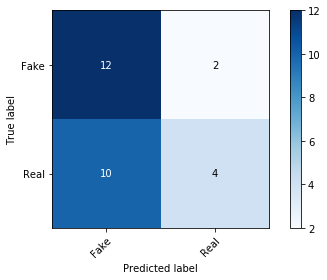

Prediction dist


False    0.785714
True     0.214286
dtype: float64

TRAIN ACCURACY: 0.919
TRAIN MAP: 0.992
TEST ACCURACY: 0.571
TEST MAP: 0.674


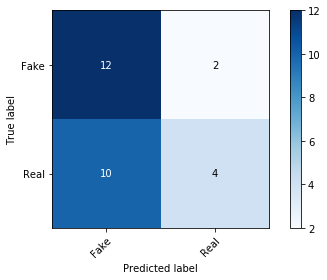

Prediction dist


False    0.821429
True     0.178571
dtype: float64

TRAIN ACCURACY: 0.919
TRAIN MAP: 0.992
TEST ACCURACY: 0.607
TEST MAP: 0.698


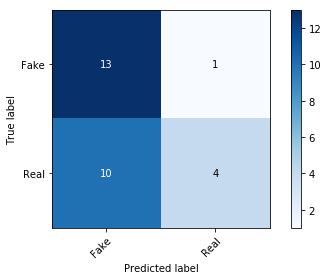

Prediction dist


False    0.821429
True     0.178571
dtype: float64

TRAIN ACCURACY: 0.919
TRAIN MAP: 0.992
TEST ACCURACY: 0.607
TEST MAP: 0.708


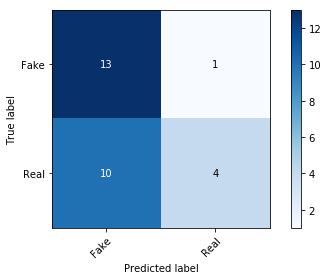

Prediction dist


False    0.821429
True     0.178571
dtype: float64

TRAIN ACCURACY: 0.919
TRAIN MAP: 0.992
TEST ACCURACY: 0.607
TEST MAP: 0.714


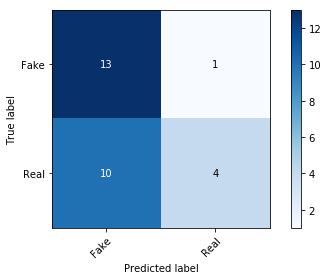

Prediction dist


False    0.785714
True     0.214286
dtype: float64

TRAIN ACCURACY: 0.919
TRAIN MAP: 0.992
TEST ACCURACY: 0.571
TEST MAP: 0.684


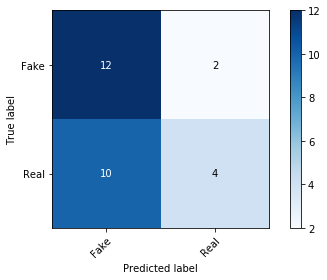

Prediction dist


False    0.821429
True     0.178571
dtype: float64

TRAIN ACCURACY: 0.919
TRAIN MAP: 0.992
TEST ACCURACY: 0.607
TEST MAP: 0.720


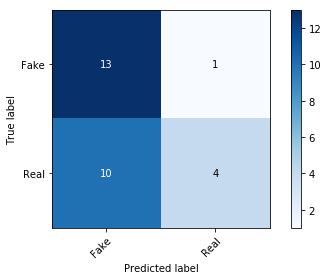

Prediction dist


False    0.821429
True     0.178571
dtype: float64

TRAIN ACCURACY: 0.919
TRAIN MAP: 0.992
TEST ACCURACY: 0.607
TEST MAP: 0.690


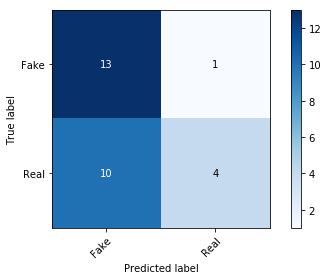

Prediction dist


False    0.857143
True     0.142857
dtype: float64

TRAIN ACCURACY: 0.919
TRAIN MAP: 0.992
TEST ACCURACY: 0.643
TEST MAP: 0.763


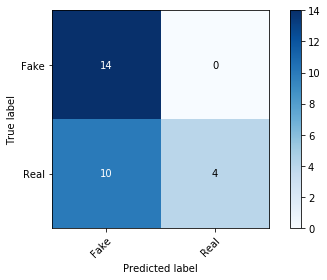

Prediction dist


False    0.785714
True     0.214286
dtype: float64

TRAIN ACCURACY: 0.919
TRAIN MAP: 0.992
TEST ACCURACY: 0.571
TEST MAP: 0.702


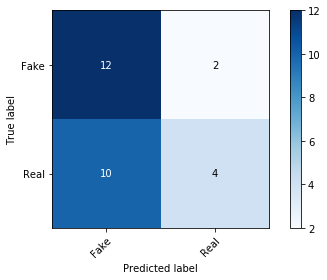

train_accs  test_accs  train_map   test_map
count  1.000000e+01  10.000000      10.00  10.000000
mean   9.189000e-01   0.596400       0.99   0.703260
std    1.170278e-16   0.024117       0.00   0.025763
min    9.189000e-01   0.571400       0.99   0.674000
25%    9.189000e-01   0.571400       0.99   0.685650
50%    9.189000e-01   0.607100       0.99   0.700150
75%    9.189000e-01   0.607100       0.99   0.712475
max    9.189000e-01   0.642900       0.99   0.763100

In [83]:
train_accs = []
test_accs = []
train_map = []
test_map = []


print('Cross validation...')

for i, (_, _, X_test, y_test) in enumerate(splits):   

    pred = model.predict(X_test)
    
    print('Prediction dist')
    display(pd.Series(pred).value_counts(normalize=True))

    pred_train = model.predict(X_train)
    train_acc = accuracy_score(y_train, pred_train)
    train_accs.append(round(train_acc, 4))
    print('TRAIN ACCURACY: {0:.3f}'.format(train_acc))
    #train_f1 = f1_score(y_train, pred_train)
    #print('TRAIN F1: {0:.3f}'.format(train_f1))
    #train_f1s.append(train_f1)
    
    y_scores = model.predict_proba(X_train)[:,1]
    mean_prec = average_precision_score(y_train, y_scores)
    train_map.append(round(mean_prec, 2))
    print('TRAIN MAP: {0:.3f}'.format(mean_prec))
    
    test_acc = accuracy_score(y_test, pred)
    test_accs.append(round(test_acc, 4))
    print('TEST ACCURACY: {0:.3f}'.format(test_acc))
#     test_f1 = f1_score(y_test, pred)
#     print('TEST F1: {0:.3f}'.format(test_f1))
#     test_f1s.append(test_f1)
    
    y_scores = model.predict_proba(X_test)[:,1]
    mean_prec = average_precision_score(y_test, y_scores)
    test_map.append(round(mean_prec, 4))
    print('TEST MAP: {0:.3f}'.format(mean_prec))
    
    
    plot_confusion_matrix(y_test, pred)
    plt.show()


    #print(pipeline.named_steps.union.transformer_list[0][1].steps[1][1].vocabulary_)

results = pd.DataFrame()
results['train_accs'] = train_accs
results['test_accs'] = test_accs
results['train_map'] = train_map
results['test_map'] = test_map
results.describe()

In [84]:
results.describe()

train_accs  test_accs  train_map   test_map
count  1.000000e+01  10.000000      10.00  10.000000
mean   9.189000e-01   0.596400       0.99   0.703260
std    1.170278e-16   0.024117       0.00   0.025763
min    9.189000e-01   0.571400       0.99   0.674000
25%    9.189000e-01   0.571400       0.99   0.685650
50%    9.189000e-01   0.607100       0.99   0.700150
75%    9.189000e-01   0.607100       0.99   0.712475
max    9.189000e-01   0.642900       0.99   0.763100

In [82]:
results.describe()

train_accs  test_accs  train_map   test_map
count  1.000000e+01  10.000000      10.00  10.000000
mean   9.189000e-01   0.596400       0.99   0.703260
std    1.170278e-16   0.024117       0.00   0.025763
min    9.189000e-01   0.571400       0.99   0.674000
25%    9.189000e-01   0.571400       0.99   0.685650
50%    9.189000e-01   0.607100       0.99   0.700150
75%    9.189000e-01   0.607100       0.99   0.712475
max    9.189000e-01   0.642900       0.99   0.763100

In [ ]:
mean	0.901860	0.564260	0.99	0.666720

In [58]:
def plot_confusion_matrix(y_true, y_pred, classes=['Fake', 'Real'],
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [57]:
def f_importances(coef, names, n=10):
    imp = coef
    sorted_tuples = sorted(zip(imp, names))
    best = sorted_tuples[-n:]
    worst = [x for x in sorted_tuples[:n] if x[0] != 0]
    imp,names =zip(*worst + best)
    plt.figure(figsize=(n/5, n/2))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names, fontsize=12)
    plt.show()

In [3]:
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
coef = pipeline.named_steps.clf.coef_.toarray().reshape(-1)
f_names = get_feature_names(pipeline)
f_importances(coef, f_names, n=20)

NameError: name 'steps' is not defined

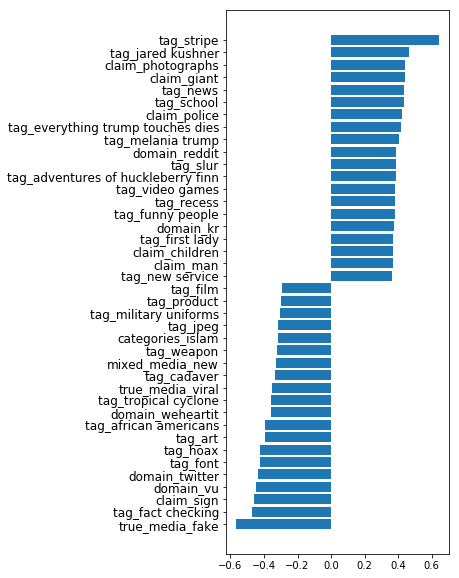

In [58]:
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
coef = pipeline.named_steps.clf.coef_.toarray().reshape(-1)
f_names = get_feature_names(pipeline)
f_importances(coef, f_names, n=20)

In [31]:
from scipy.sparse import coo_matrix, hstack

In [60]:
p = Pipeline([
                        ('selector', BowSelector(key='media_titles_true')),
                        ('bow', CountVectorizer(stop_words='english', 
                                                #min_df=0.005,
                                          analyzer=partial(prefix_analyzer, prefix='true_media'))),
         ('scaler', StandardScaler(with_mean=False))])

In [67]:
p =     Pipeline([
        ('selector', BowSelector(key='descriptions')),
        ('bow', CountVectorizer(stop_words='english', 
                             #min_df=0.01,
                              # max_features=100,
                          analyzer=partial(prefix_analyzer, prefix='tag', tokenizer=tag_tokenizer),
                          )),
                        ('scaler', MaxAbsScaler()),
    ])

In [68]:
X_transf = p.fit_transform(X_train, y_train)

In [69]:
X_transf.shape

(1184, 6386)

In [70]:
X_transf_labeled = hstack([y_train.astype(int)[:,None], X_transf]).A

In [71]:
X_transf_labeled.shape

(1184, 6387)

In [74]:
np.savetxt('tags_scaled.csv', X_transf_labeled.astype(int), fmt='%i', delimiter=" ")